## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Overview
In a world where Microsoft is considering developing original content, I'm tasked with providing recommendations for what types of feature films Microsoft should invest in. I used data from the Internet Movie Database (IMDB) and The Numbers to explore the features of films from 2009-2019 to understand what makes for a successful film. 

After a cursory exploration of the data, I can offer the following insights into the data:
* International appeal is essential to profitability
* Big adventure/sci-fi blockbusters are an aspirational, long-term goal
* Genres like Drama and Comedy are easy entry points

## Business Problem
In setting out on this exploratory analysis, I had two key questions:
* What are the defining characteristics of a film (from a data perspective)?
* How is success defined for the film industry?

Ultimately, determining what metrics were most essential to a film's "identity" was determined by the available data. Understanding the genre, the earnings, and audience reception are decent measures of a film, particularly when limited to quantitative data. 

Defining the success of a film is relatively straightforward. Did the film make money? Was it a good investment? It's also important to consider how a film contributed to the brand identity of the studio, which is an essential consideration in this stage of development.

## Data Understanding
The first source of data, IMDB, was an easy choice. IMDB is considered a highly reliable source of information on the film industry, by viewers and professionals within the industry alike. The Numbers database is a more specialized source of information specific to business analytics. 

Of primary consideration where the following variables:
  * genres (up to three)
  * average audience rating
  * number of votes
  * production budget
  * domestic gross
  * worldwide gross

I chose to limit the timeframe of this analysis to 2009-2019. I wanted to limit the exploration to relatively recent films to offer the best insight into the industry today. I also wanted a sample of films that captured the industry before and after inital entries from two major tech startups; Netflix and Amazon both released their first theatrical releases in 2015. 

I also limited my exploration to major theatrical releases. The primary rationale for this was that such releases offered reliable box office data a clear indicator of financial success. 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [7]:
#import the IMDB titles dataframe and set the unique film identifier as the index
df_imdb_title = pd.read_csv("zippedData/imdb.title.basics.csv.gz")
df_imdb_title.set_index('tconst', inplace=True)

#import the IMDB ratings dataframe and set the unique film identifier as the index
df_imdb_ratings = pd.read_csv("zippedData/imdb.title.ratings.csv.gz")
df_imdb_ratings.set_index('tconst', inplace=True)

#merge the film and ratings data
df_imdb_merge = df_imdb_title.join(df_imdb_ratings)

In [8]:
#import The Numbers data
df_tn_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

## Data Preparation

I was fortunate to have a relatively straightforward set of data to work with. Although there was some missing data in the IMDB tables, the overall data was so exhaustive (including made-for-TV or direct-to-DVD films) that I was not particularly concerned about missing data. 

The first challenge was to separate the 'genres' column into distinct columns. This offered much more freedom to explore data grouped by genre, but also caused many films to be counted multiple times in the data, as they were represented by multiple genres. 

The most complex issue I faced in this project was in merging the IMDB and The Numbers dataframes. The only potential key was the film title, which was unreliable at best. I tried many methods of normalizing the data or creating keys, but each attempt proved to have more casualties than the last. Ultimately, I lost aprocimately 20% of the data in merging the two dataframes, which is a considerable liability in this exploration. 

### IMDB Data

After combining the two IMDB dataframes, I wanted to check to see how much data was missing. After seeing a significant amount, I took some time to go through the data manually, and I felt that I was data that I wouldn't end up using, so I felt comfortable dropping those rows

In [9]:
#check the integrity of the merged data
df_imdb_merge.isna().sum()
#after exploring the data manually, I felt confident dropping rows that were missing
# genres, average ratings, and number of votes
df_imdb_merge.dropna(subset=['genres', 'averagerating', 'numvotes'], inplace=True)

I disaggregated the genres data, turning a list of several columns delimited with ',' to separate columns for each genre, with a 1 or 0 in the column to indicate whether the film belonged to it. 
(This function was covered in class.)

In [10]:
# This is the genre separation function from study group

def make_genre_columns(dataframe, genre_col_name='genres'):
    '''
    '''
    ##get list of unique genres
    #join all the (unique) genre values into one big string
    list_all_genres = ','.join(dataframe[genre_col_name].unique())
    #get a set of all unique genres wo duplicates
    unique_genres = set(list_all_genres.split(','))
    
    ## create new columns witht he genres and populate with 0/1
    #make safe copy
    new_dataframe = dataframe.copy(deep=True)
    for genre in unique_genres:
        new_dataframe[genre] = new_dataframe[genre_col_name].map(lambda val: 1 if genre in val else 0)
    
    #drop unused genre column    
    new_dataframe = new_dataframe.drop([genre_col_name], axis=1)
    return new_dataframe
#execute and view
df_imdb_genres = make_genre_columns(df_imdb_merge)

At this point, the IMDB data was ready to merge

### The Numbers
The Numbers dataframe was much smaller than the IMDB dataframe, so I decided to focus on the films it contained as my scope. 
I cleaned the data by type casting the columns to what I needed them to be.

In [11]:
#change the date to a datetime object
df_tn_budgets['release_date'] = pd.to_datetime(df_tn_budgets['release_date'])

#turn the budget and gross columns into ints
# I tried to find a better way to do this but they were all more trouble than they were worth
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

for c in cols:
    df_tn_budgets[c] = df_tn_budgets[c].str.replace('$', "")
    df_tn_budgets[c] = df_tn_budgets[c].str.replace(',', "")
    df_tn_budgets[c] = df_tn_budgets[c].astype('float')     #values were too big for int

Then, I created new columns for International Gross, Net Profit, and ROI

In [12]:
#create a column of the total gross
df_tn_budgets["intl_gross"] = df_tn_budgets['worldwide_gross'] - df_tn_budgets['domestic_gross']

#create a net profit column
df_tn_budgets["net_profit"] = df_tn_budgets['worldwide_gross'] - df_tn_budgets['production_budget']

#create ROI column
df_tn_budgets['roi'] = df_tn_budgets['net_profit'] / df_tn_budgets['production_budget']

I knew I wanted to focus on the release year, so I pulled the year out of the datetime object, then eliminated all films released before 2009

In [13]:
#pull release year out of the datetime for groupby purposes (found on slackoverflow)
df_tn_budgets['release_year'] = df_tn_budgets['release_date'].map(lambda x: x.strftime('%Y'))
#cast year column as int
df_tn_budgets['release_year'] = df_tn_budgets['release_year'].astype(int)

#pull out only films from 2009 and after
current_tn_budgets = df_tn_budgets.loc[df_tn_budgets['release_year'] >= 2009]


<AxesSubplot:xlabel='release_year'>

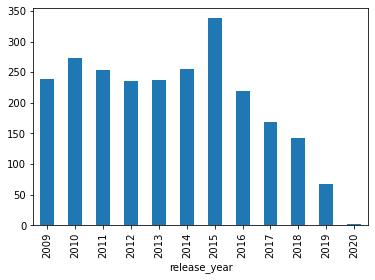

In [14]:
#let's see how many films from each year we have
grouped = current_tn_budgets.groupby("release_year")
grouped['release_year'].count().plot.bar()

I wanted a quick look at the top ROI films in the dataset, so I printed the column. I was struck by the amount of horror films on this list, but I also noticed a couple of standouts : Get Out and Moonlight were both nominated for Academy Awards in major categories.

In [30]:
#see ROI 
current_tn_budgets.sort_values(by=['roi'], ascending = False).head(15)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,intl_gross,net_profit,roi,release_year,normalized_title
5492,93,2009-09-25,Paranormal Activity,450000.0,107918810.0,194183034.0,86264224.0,193733034.0,430.517853,2009,paranormalactivity
5679,80,2015-07-10,The Gallows,100000.0,22764410.0,41656474.0,18892064.0,41556474.0,415.564740,2015,thegallows
5211,12,2012-01-06,The Devil Inside,1000000.0,53262945.0,101759490.0,48496545.0,100759490.0,100.759490,2012,thedevilinside
5459,60,2009-04-23,Home,500000.0,15433.0,44793168.0,44777735.0,44293168.0,88.586336,2009,home
5062,63,2011-04-01,Insidious,1500000.0,54009150.0,99870886.0,45861736.0,98370886.0,65.580591,2011,insidious
5213,14,2015-04-17,Unfriended,1000000.0,32789645.0,64364198.0,31574553.0,63364198.0,63.364198,2015,unfriended
4664,65,2010-10-20,Paranormal Activity 2,3000000.0,84752907.0,177512032.0,92759125.0,174512032.0,58.170677,2010,paranormalactivity2
4249,50,2017-01-20,Split,5000000.0,138141585.0,278964806.0,140823221.0,273964806.0,54.792961,2017,split
5189,90,2014-03-21,Godâs Not Dead,1150000.0,60755732.0,63777092.0,3021360.0,62627092.0,54.458341,2014,godâsnotdead
4248,49,2017-02-24,Get Out,5000000.0,176040665.0,255367951.0,79327286.0,250367951.0,50.073590,2017,getout


I created a function to normalize the titles to make them more reliable as a joining index. 

In [16]:
# This is the simpler of two string normalizing functions I created, and the one I ultimately used
def normalize_string_mild(title):

    new_title = ''.join(filter(str.isalnum, title))    #from stackoverflow
    new_title = new_title.lower()
    
    return new_title

I then normalized the IMDB dataframe and the Numbers dataframe and merged them alongsize the normalized titles

In [21]:
#create a normalized title column in the IMDB dataframe
df_imdb_genres['normalized_title'] = df_imdb_genres['primary_title'].map(normalize_string_mild)
#create a normalized title column in the TN dataframe

#I got a warning about this one that stackoverflow told me to fix by making a copy
df_budgets_copy = current_tn_budgets.copy(deep=True)
df_budgets_copy['normalized_title'] = df_budgets_copy['movie'].map(normalize_string_mild) #it worked

#merge the datasets on the normalized title column
df_merge_inclusive = df_budgets_copy.merge(df_imdb_genres, how="left", right_on='normalized_title', left_on="normalized_title")

This was where I ran into trouble. I lost a lot of data on this merge, including many major films. I tried to create a key by combining keywords from the title and the year, but I ultimatly ended up with less reliable data as a result. Since I wanted to primarily explore the genre data and I could not think of a way to reliably fill in that data, I chose to drop the cells. This is a huge liability and is evident in the data moving forward.

In [22]:
df_merge_inclusive.dropna(inplace=True)  #have 2168 values remaining
df_merge_inclusive.drop_duplicates(subset=['release_date', 'primary_title'], inplace=True) #mourn the losses

I went ahead and dropped genre columns that did not have any films in them, and removed 2020, as it only contained production data for films, with no box office. 

In [ ]:
#remove genre columns with all zero values
df_merge_inclusive = df_merge_inclusive.loc[:, (df_merge_inclusive!=0).any(axis=0)] #thanks stackoverflow

#remove 2020
df_merge_inclusive = df_merge_inclusive.loc[df_merge_inclusive['release_year'] < 2020]

## Data Modeling

Knowing that the genres were going to be a focus of my analysis, I chose to create a visualization to explore the genre spread of the dataset

[Text(0.5, 1.0, 'Count of Films in the Dataset (2009-2019)'),
 Text(0, 0.5, 'number of films'),
 Text(0.5, 0, 'genre')]

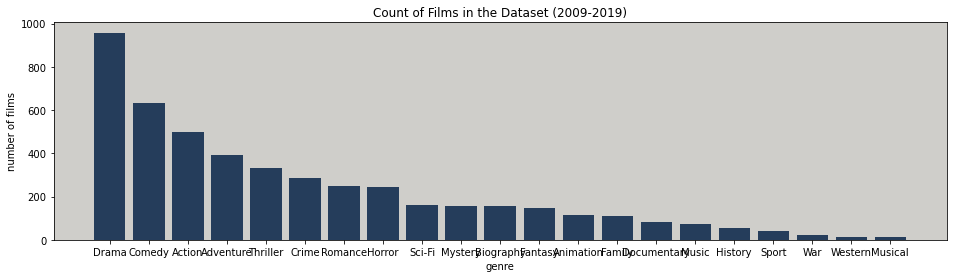

In [95]:
#list of genres
genres_list = ['Drama', 'Fantasy', 'Adventure', 'Crime', 'Sport', 'Western', 'Biography', 
               'Romance', 'History', 'Documentary', 'War', 'Comedy', 'Horror', 'Family',
              'Music', 'Action', 'Thriller', 'Musical', 'Mystery', 'Sci-Fi', 'Animation']

#create figure big enough that labels are legible
fig, ax = plt.subplots(figsize=(16, 4))

#set Y axis to the number of films per genre in the dataset
y = df_merge_inclusive[genres_list].sum().sort_values(ascending=False)

#keep a sorted version of the dataset for nicer visualizations
sorted_genres = y.index.tolist() 

#plot the bar graph
ax.bar(x=sorted_genres, height=y, color='#253d5b')
ax.set_facecolor("#cfceca")
#add labels
ax.set(title='Count of Films in the Dataset (2009-2019)',
      ylabel='number of films',
      xlabel='genre')


Then I wanted to see if there were any trends in genre over time. 

[Text(0.5, 1.0, 'Worldwide Gross Box Office by Genre (2009-2019)'),
 Text(0, 0.5, 'gross box office USD (in billions)'),
 Text(0.5, 0, 'year')]

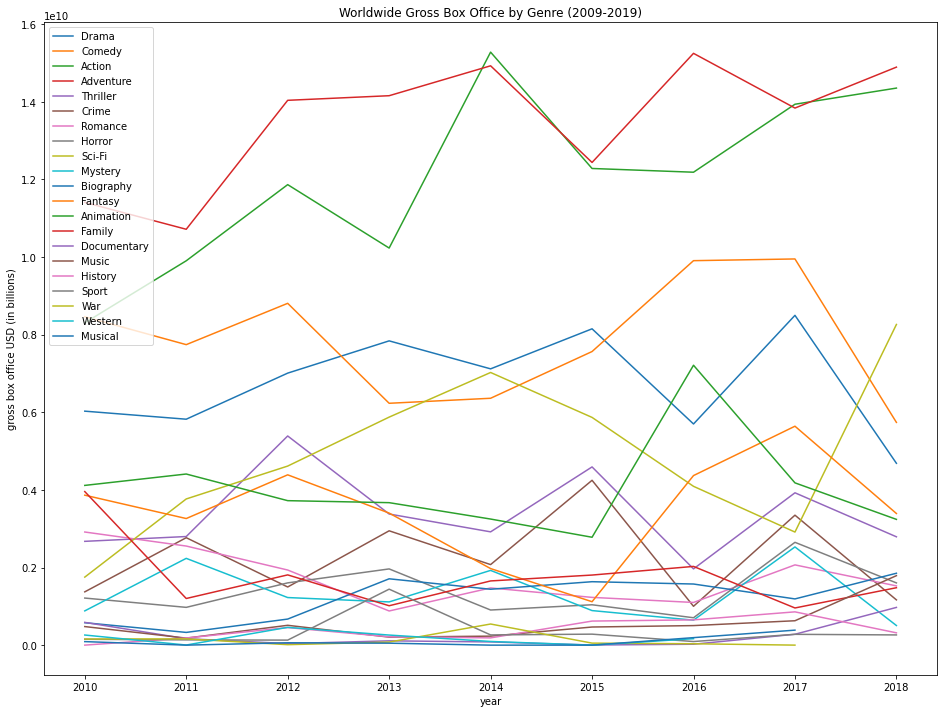

In [49]:
#I didn't have enough data in these years to create a useful image
df_lines = df_merge_inclusive.loc[df_merge_inclusive["release_year"] < 2019]
df_lines = df_lines.loc[df_lines["release_year"] > 2009]

#establish matplotlib figure
fig, ax = plt.subplots(figsize=(16,12))
#this line ensures that each year will have its own tick
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

#loop through the genres
for genre in sorted_genres:
    #create a dataframe for each genre
    df = df_lines.loc[df_lines[genre] == 1]
    
    #group dataframe by release year
    grouped = df.groupby('release_year')
    #set the x axis to the year
    x=grouped['release_year'].sum().index
    #sum the worldwide gross
    y=grouped['worldwide_gross'].sum()

    #plot it
    ax.plot(x,y)
    
#make a legend
ax.legend(sorted_genres, loc='upper left')

#add labels
ax.set(title='Worldwide Gross Box Office by Genre (2009-2019)',
      ylabel='gross box office USD (in billions)',
      xlabel='year')

Wow, that's a terrible graph! But I'm committed to this concept, so let's pull out the interesting data points.

In the chart below, I pull out some of the more interesting data points. This chart helps establish the genres that are most of interest in this analysis. Action, Adventure, and Sci-Fi are all trending upwards, meaning that they'll be popular for some time. While Drama and Comedy are in decline, they still rank in the top 20% of genres.

[Text(0.5, 1.0, 'Worldwide Gross Box Office by Genre (2009-2019)'),
 Text(0, 0.5, 'gross box office USD (in billions)'),
 Text(0.5, 0, 'year')]

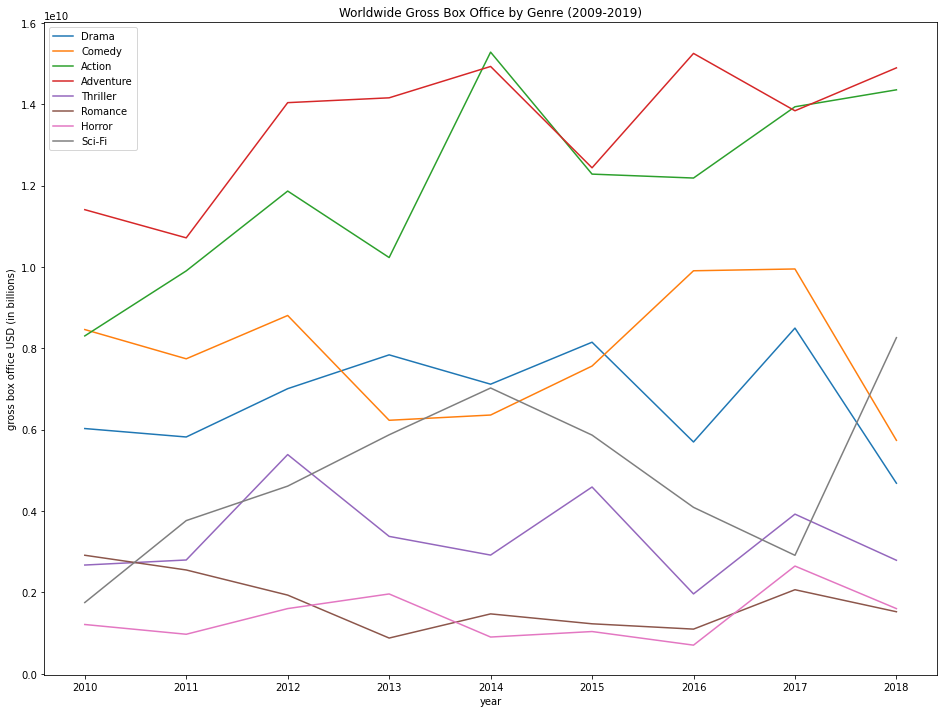

In [51]:
#pull out some interesting genres to minimize the chaos
selected_genres = ['Drama', 'Comedy', 'Action', 'Adventure', 'Thriller', 'Romance', 'Horror', 'Sci-Fi']

#estbalish matplotlib figure
fig, ax = plt.subplots(figsize=(16,12))

#this line ensures every year is printed
ax.xaxis.set_major_locator(plt.MultipleLocator(1)) 

#loop through each genre
for genre in selected_genres:
    #create a dataframe for the genre
    df = df_lines.loc[df_lines[genre] == 1]
    
    #group the dataframe by the release year
    grouped = df.groupby('release_year')
    #creates an x-axis with each year
    x=grouped['release_year'].sum().index
    #y axis is the total gross for that year
    y=grouped['worldwide_gross'].sum()

    #plot it
    ax.plot(x,y)
    
#make a legend
ax.legend(selected_genres, loc='upper left')

#add labels
ax.set(title='Worldwide Gross Box Office by Genre (2009-2019)',
      ylabel='gross box office USD (in billions)',
      xlabel='year')

Next, I wanted better insights into the ratio of domestic to international gross box office was. I started with the stacked bar chart for the years.

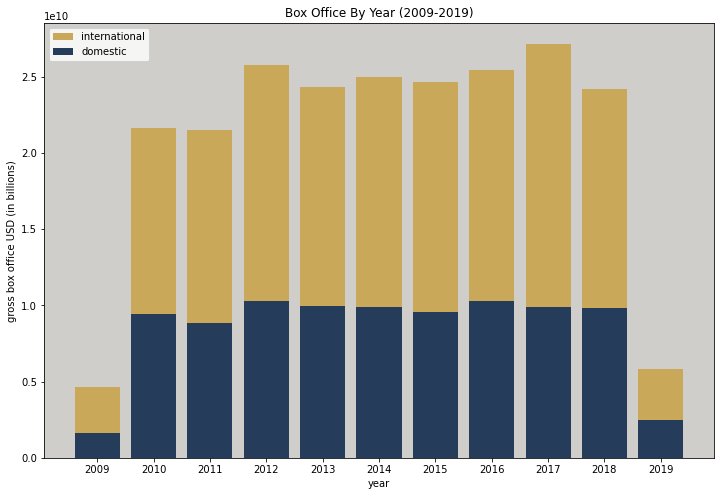

In [94]:
#group the data by release year
year_group = df_merge_inclusive.groupby("release_year")

#create matplotlib 
fig, ax = plt.subplots(figsize = (12, 8))
ax.set_facecolor("#cfceca")

#this line ensures every year is printed
ax.xaxis.set_major_locator(plt.MultipleLocator(1)) 

#x is the year
x = year_group['release_year'].mean().index
# y is domestic and international gross
y = year_group['domestic_gross'].sum()
y2 = year_group['intl_gross'].sum()

#doing it in this order makes the legend look nicer
#stack the y 
ax.bar(x, y2, bottom=y, color='#c9a959', label = 'international') 
ax.bar(x, y, color='#253d5b', label = 'domestic')


#make a legend
ax.legend(loc='upper left')

#add labels
ax.set(title='Box Office By Year (2009-2019)',
      ylabel='gross box office USD (in billions)',
      xlabel='year')

plt.show()

Because there were so many entries in the genres category, and to best display the relationship between domestic/international/and worldwide, I chose to create a stacked boxplot of percentages. This plot shows which genres are most reliant on interest on a global scale.

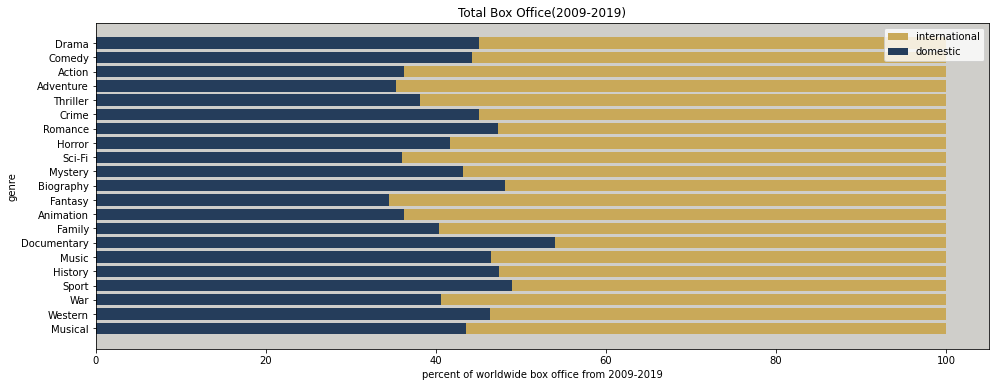

In [93]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_facecolor("#cfceca")
#cycle through the genres
for idx, genre in enumerate(reversed(sorted_genres)):    #Reversed puts the more popular genres at the top
    df = df_merge_inclusive.loc[df_merge_inclusive[genre] == 1]
    
    x = genre
    #calculate the domestic percentage of total gross
    y = df['domestic_gross'].sum() / df['worldwide_gross'].sum()  * 100 
    #calculate the international percentage of total gross
    y2 = df['intl_gross'].sum() / df['worldwide_gross'].sum() * 100
    
    #so the legend labels only happen once
    if idx == 1:
        #order is for the legend also
        p2 = plt.barh(x, y2, left=y, color='#c9a959', label = 'international')
        p1 = plt.barh(x, y, color='#253d5b', label = 'domestic')
        

    #these ones don't need labels    
    p1 = plt.barh(x, y, color='#253d5b')
    p2 = plt.barh(x, y2, left=y, color='#c9a959')

#make a legend
ax.legend(loc='upper right')

#add labels
ax.set(title='Total Box Office(2009-2019)',
      ylabel='genre',
      xlabel='percent of worldwide box office from 2009-2019')
plt.show()

Next, I wanted a breakdown of global box office by genre, just as a formality.

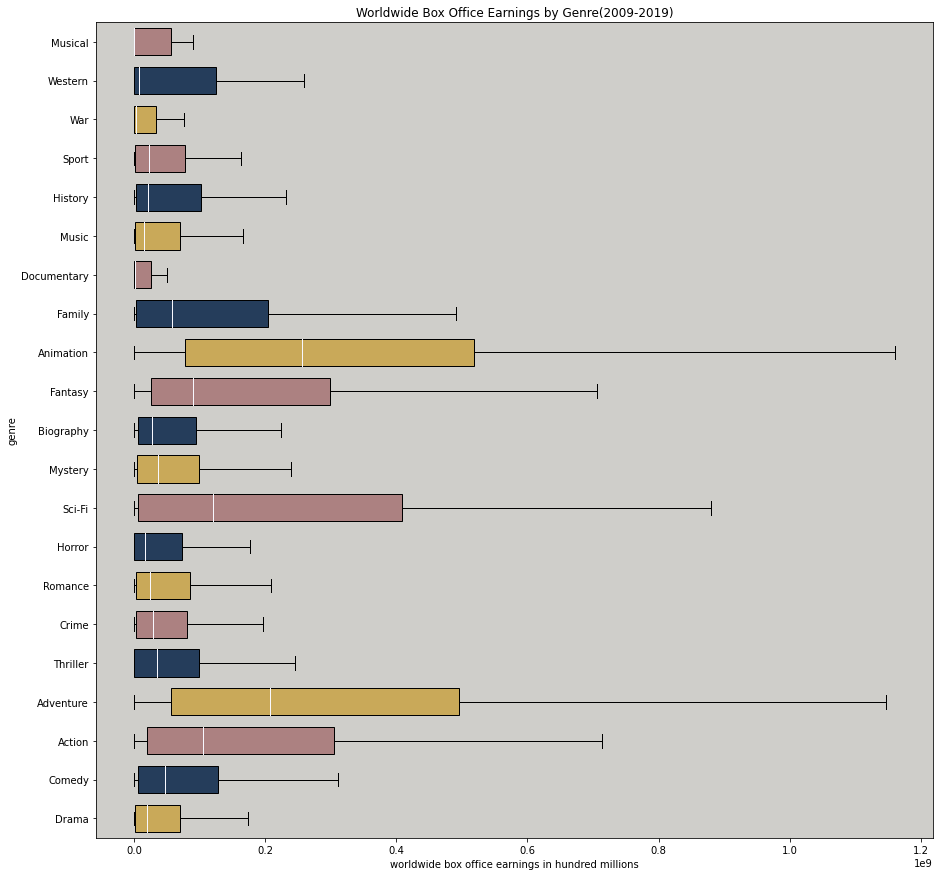

In [101]:
#establish plot size
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor("#cfceca")

colors = ['#c9a959', '#253d5b', '#ac8181']

#loop through the genres, enumerate comes in handy later
for idx, genre in enumerate(sorted_genres):
    #create a dataframe unique to the genre
    df = df_merge_inclusive.loc[df_merge_inclusive[genre] == 1]
    
    #data to plot is the worldwide gross for the genre
    data = df['worldwide_gross']
    
    #create plot: positions separates the plots so they don't stack
    b = plt.boxplot(data, positions = [idx], vert = False, widths = 0.7,
              patch_artist = True, showfliers=False)
    #do the colors
    plt.setp(b["boxes"], facecolor=colors[idx%3])
    plt.setp(b['medians'], color = '#f8f8ff')

#label each box
ax.set_yticklabels(sorted_genres)

#add labels
ax.set(title='Worldwide Box Office Earnings by Genre(2009-2019)',
      ylabel='genre',
      xlabel='worldwide box office earnings in hundred millions')
plt.show()

After looking at earnings, I wanted to understand the opportunity cost of creating films. This metric seemed like it would be particularly useful at this stage in the venture. It was this visualization that helped me land on Drama and Comedy as a starting point for an early stage studio.

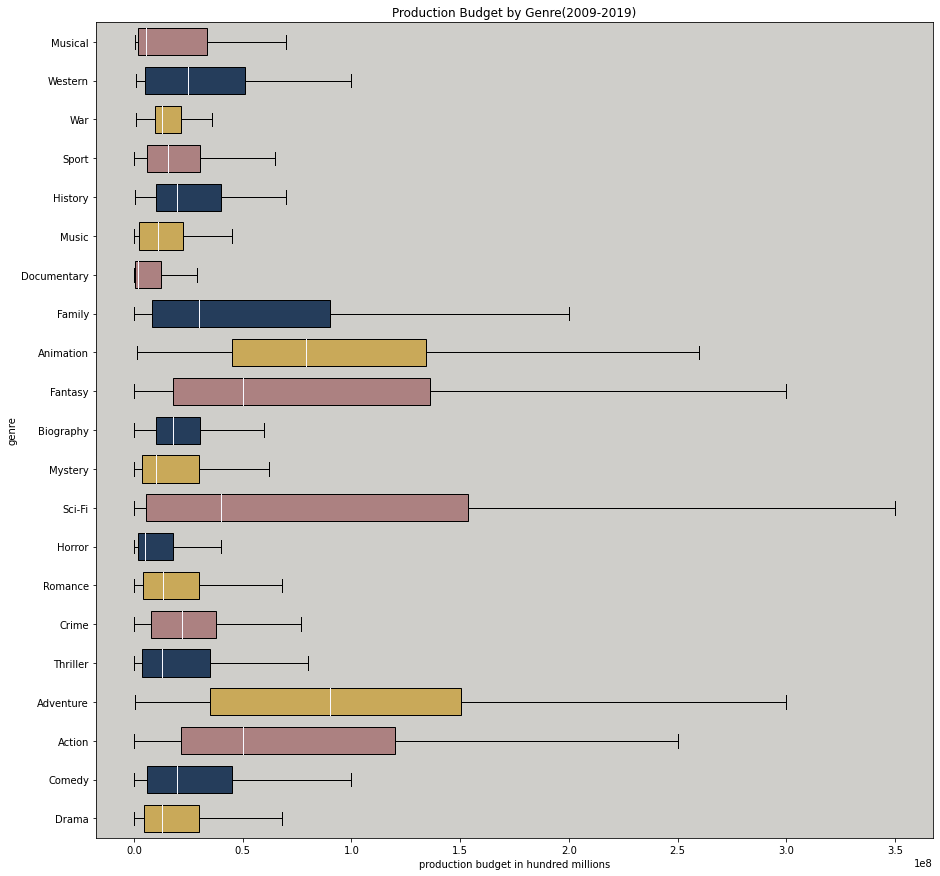

In [103]:
#establish plot size
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor("#cfceca")

colors = ['#c9a959', '#253d5b', '#ac8181']

#loop through the genres, enumerate comes in handy later
for idx, genre in enumerate(sorted_genres):
    #create a dataframe unique to the genre
    df = df_merge_inclusive.loc[df_merge_inclusive[genre] == 1]
    
    #data to plot is the worldwide gross for the genre
    data = df['production_budget']
    
    #create plot: positions separates the plots so they don't stack
    b = plt.boxplot(data, positions = [idx], vert = False, widths = 0.7,
              patch_artist = True, showfliers=False)
    #do the colors
    plt.setp(b["boxes"], facecolor=colors[idx%3])
    plt.setp(b['medians'], color = '#f8f8ff')

#label each box
ax.set_yticklabels(sorted_genres)

#add labels
ax.set(title='Production Budget by Genre(2009-2019)',
      ylabel='genre',
      xlabel='production budget in ten millions')
plt.show()

Finally, I wanted to look at ratings to see if there was any indication of what types of films rated well with viewers. Ultimately, I felt that the ratings scatterplots demonstrated more about human rating behavior (still interesting!) than any patterns that would be useful for understanding film success. It did point to some genres that might be riskier than others (Horror and Sci-Fi)
I did have a hypothesis that the number of ratings would be an indicator of a film's success ('engagement' with the film) but the scatterplots demonstrated that that was only true for a very small handful of outliers. 

[Text(0.5, 1.0, 'Films by IMDB Rating'),
 Text(0, 0.5, 'average rating'),
 Text(0.5, 0, 'number of ratings in hundred thousands')]

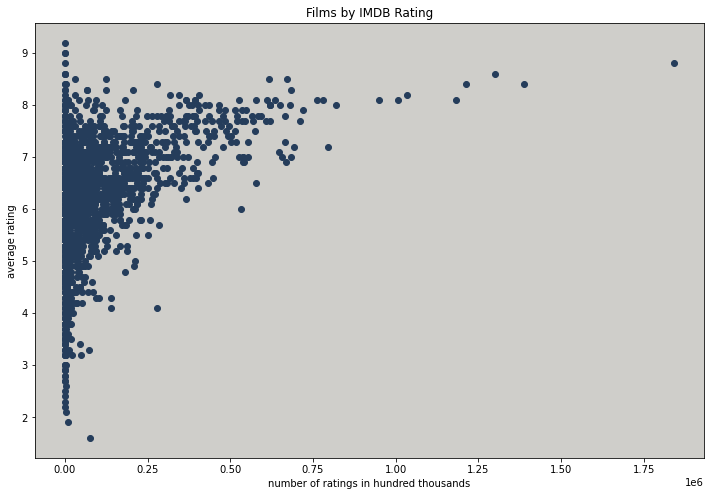

In [122]:
#Create a simple scatter plot comparing ratings by the average number of votes
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor("#cfceca")
x = df_merge_inclusive['numvotes']
y = df_merge_inclusive['averagerating']
ax.plot(x, y, 'o', color = '#253d5b')

ax.set(title='Films by IMDB Rating',
      ylabel='average rating',
      xlabel='number of ratings in hundred thousands')

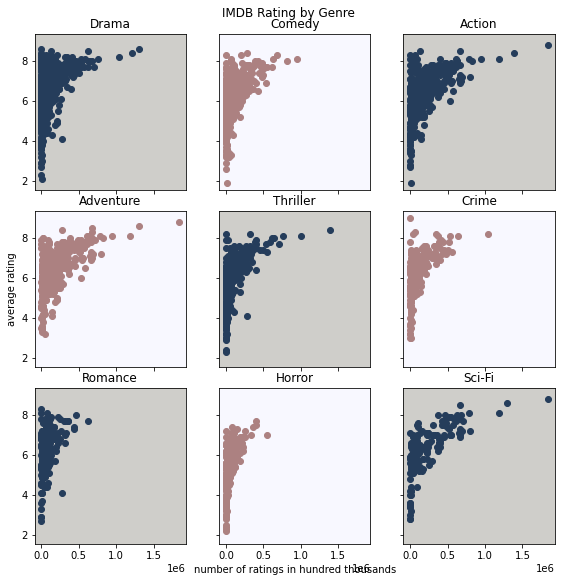

In [120]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8, 8))
fig.suptitle('IMDB Rating by Genre')
fig.tight_layout()
facecolors = ['#cfceca', '#f8f8ff']
dotcolors = ['#253d5b','#ac8181' ]
for n in range(9):
    df = df_merge_inclusive.loc[df_merge_inclusive[sorted_genres[n]] == 1]
    
    row = n//3
    col = n%3
    ax = axes[row][col]
    ax.set_facecolor(facecolors[n%2])
    
    x = df['numvotes']
    y = df['averagerating']
    
    ax.plot(x, y, 'o', color=dotcolors[n%2])
   
    ax.set_title(sorted_genres[n])


axes[1][0].set_ylabel('average rating')
axes[2][1].set_xlabel('number of ratings in hundred thousands')
plt.show()

In [121]:
#separate the highest-rated films
highly_rated = df_merge_inclusive.loc[df_merge_inclusive["averagerating"] > 8]

#calculate the average number of votes
numvotes_mean = df_merge_inclusive["numvotes"].mean()

#grab films that are highly rated by many reviewers
highly_rated.loc[highly_rated["numvotes"] > numvotes_mean]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,intl_gross,net_profit,roi,release_year,...,Adult,Crime,Mystery,Family,News,Western,Horror,Thriller,Comedy,War
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,1.748134e+09,5.827114,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11,2012-07-20,The Dark Knight Rises,275000000.0,448139099.0,1.084439e+09,6.363000e+08,8.094391e+08,2.943415,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,8.946564e+08,1.292936e+09,5.746382,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,47,2010-06-18,Toy Story 3,200000000.0,415004880.0,1.068880e+09,6.538746e+08,8.688795e+08,4.344398,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
92,2,2017-11-22,Coco,175000000.0,209726015.0,7.980081e+08,5.882821e+08,6.230081e+08,3.560046,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101,14,2014-08-01,Guardians of the Galaxy,170000000.0,333172112.0,7.708675e+08,4.376954e+08,6.008675e+08,3.534515,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
115,30,2010-03-26,How to Train Your Dragon,165000000.0,217581232.0,4.948710e+08,2.772898e+08,3.298710e+08,1.999218,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,32,2014-11-05,Interstellar,165000000.0,188017894.0,6.663794e+08,4.783615e+08,5.013794e+08,3.038663,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,38,2010-07-16,Inception,160000000.0,292576195.0,8.355246e+08,5.429484e+08,6.755246e+08,4.222029,2010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,75,2015-05-15,Mad Max: Fury Road,150000000.0,153636354.0,3.700980e+08,2.164617e+08,2.200980e+08,1.467320,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluation
After this exploratory analysis, I felt that there was so much left to learn about films and the film industry. This exploration barely scratches the surface, but it could offer some broad insights that might shape a larger strategic vision. 

Beginning with smaller, less risky dramas and comedies might pave the way for Microsoft to grow it's capacity to create more logistically challenging (and profitable) action/adventure and sci-fi titles. A key throughout this process will be prioritizing stories that appeal to a global audience. 

Although there are many limitations to the data, I'm confident that these conclusions are representative of the industry at this time, and would be supported and enhanced by further exploration. A more complete dataset would offer more confident insights. If it is possible to find budget data that is indexed using the IMDB index, it would prevent quite a bit of lost data.

Ultimately, it is challenging to judge films, for all their complexity and subjectivity, in terms of quantitative data. This type of exploratory data analysis is at best a scaffolding for the type of knowledge that comes from close contact with the industry. 

## Conclusions

Limiting the ratings data to IMDB does bias it towards a particular type of user who is likely tech savvy and interested in films. Adding further ratings data to diversify the viewer and critic data would offer a more nuanced profile of the films in question. 

Next steps could include case studies of the first feature films from tech startup studios as well as profiles of talent in the industry (writers, directors, and actors) who fit the budget at the price point established. I would also look into the types of films that win major industry awards (Academy Awards, Golden Globes, Screen Actor's Guild, and British Academy of Film and Television Arts). 